# Standard Statistical Downscaling

## Preparing the data

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import numpy as np
from pixel_interp import PixelInterpolator

Open the GCM SSTs that we subsetted from the CMIP6 Pangeo AWS bucket

In [10]:
fname = 'tos_Omon_CanESM5_ssp126_r1i1p1f1_gr_19000101-21001231.nc'
gcm_grid = xr.open_dataset(f'/home/jovyan/shared/data/ecopro/KelpForest/cmip6/{fname}')
gcm_grid

<xarray.Dataset>
Dimensions:  (time: 2412, x: 19, y: 17)
Coordinates:
  * time     (time) object 1900-01-16 12:00:00 ... 2100-12-16 12:00:00
  * x        (x) float64 -130.0 -129.0 -128.0 -127.0 ... -114.0 -113.0 -110.0
  * y        (y) float64 26.0 27.0 28.0 29.0 30.0 ... 38.0 39.0 40.0 41.0 42.0
    lat      (y, x) float64 ...
    lon      (y, x) float64 ...
Data variables:
    tos      (time, y, x) float32 ...

Open the monthly MUR SSTs that we subsetted from the public OpenData AWS Bucket

In [11]:
mur = xr.open_dataset('/home/jovyan/shared/data/ecopro/KelpForest/MUR_kelp_27_38.nc')
mur

<xarray.Dataset>
Dimensions:            (month: 12, pts: 91374, time: 212)
Coordinates:
    lat                (pts) float64 ...
    lon                (pts) float64 ...
  * time               (time) datetime64[ns] 2002-06-30 ... 2020-01-31
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: pts
Data variables:
    analysed_sst       (time, pts) float64 ...
    analysed_sst_clim  (month, pts) float64 ...

Now we will setup the process for interpolating the gridded GCM data to the specified kelp locations. Here we use a barycentric bilinear interpolation as the kelp locations are assumed to be unstructured (a list of coordinate points).

In [12]:
df = pd.read_csv('/home/jovyan/shared/data/ecopro/KelpForest/kelp_locations_27_38.csv')
pts = np.array(list(zip(gcm_grid.lat.values.ravel(), gcm_grid.lon.values.ravel())))
interp = PixelInterpolator(pts, df.values)

Perform the interpolation of the GCM SSTs at all timesteps

In [13]:
gcm = np.asarray([interp(gcm_grid.tos[i].values.ravel()+273.15) for i in range(gcm_grid.time.size)])
gcm = xr.DataArray(gcm, dims=('time', 'pts')).assign_coords(lat=(('pts'), df.Latitude), 
                                                            lon=(('pts'), df.Longitude), 
                                                            time=gcm_grid.time)
gcm

<xarray.DataArray (time: 2412, pts: 91374)>
array([[294.62498327, 294.62136876, 294.61775426, ...,          nan,
                 nan,          nan],
       [294.21506455, 294.21120033, 294.20733611, ...,          nan,
                 nan,          nan],
       [294.22074448, 294.21723627, 294.21372806, ...,          nan,
                 nan,          nan],
       ...,
       [302.60240574, 302.59964461, 302.59688348, ...,          nan,
                 nan,          nan],
       [300.87445233, 300.87208433, 300.86971633, ...,          nan,
                 nan,          nan],
       [298.86806314, 298.86543175, 298.86280036, ...,          nan,
                 nan,          nan]])
Coordinates:
    lat      (pts) float64 27.01 27.01 27.02 27.02 ... 27.98 27.98 27.98 27.99
    lon      (pts) float64 -115.2 -115.2 -115.2 -115.2 ... -114.0 -114.0 -114.0
  * time     (time) object 1900-01-16 12:00:00 ... 2100-12-16 12:00:00
Dimensions without coordinates: pts

## Downscaling Steps

First calculate the monthly GCM SST climatology for the reference period covered by the MUR SST dataset.

In [14]:
gcm_clim = gcm.sel(time=slice('2002-06', '2020-01')).groupby('time.month').mean()

Subtract the GCM monthly SST climatology from the GCM monthly SST.

In [15]:
gcm_adj = gcm - gcm_clim.sel(month=gcm.time.dt.month)

The actual standard downscaling is complete once we re-add the monthly MUR SST to the GCM SST

In [16]:
gcm_down = gcm_adj + mur.analysed_sst_clim.sel(month=gcm.time.dt.month)
gcm_down

<xarray.DataArray (time: 2412, pts: 91374)>
array([[291.41778672, 291.41386785, 291.4099326 , ...,          nan,
                 nan,          nan],
       [290.63899043, 290.63645439, 290.63385215, ...,          nan,
                 nan,          nan],
       [290.249433  , 290.24520934, 290.24085332, ...,          nan,
                 nan,          nan],
       ...,
       [296.2398461 , 296.23807566, 296.23650985, ...,          nan,
                 nan,          nan],
       [295.97229883, 295.97038743, 295.96860009, ...,          nan,
                 nan,          nan],
       [295.23312338, 295.23218462, 295.23131824, ...,          nan,
                 nan,          nan]])
Coordinates:
    lat      (pts) float64 27.01 27.01 27.02 27.02 ... 27.98 27.98 27.98 27.99
    lon      (pts) float64 -115.2 -115.2 -115.2 -115.2 ... -114.0 -114.0 -114.0
  * time     (time) object 1900-01-16 12:00:00 ... 2100-12-16 12:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: pts

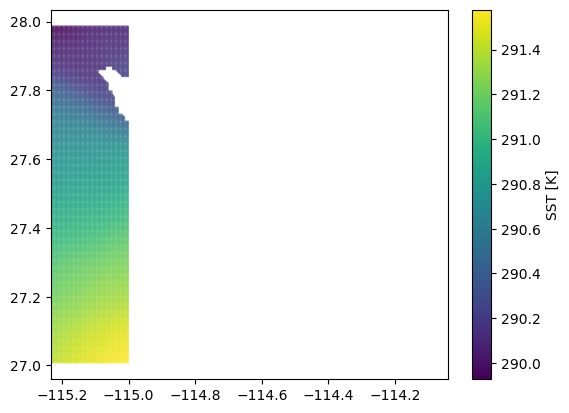

In [19]:
plt.scatter(gcm_down.lon.values, gcm_down.lat.values, c=gcm_down.isel(time=0).values, s=0.1)
plt.xlim(gcm_down.lon.min(), gcm_down.lon.max())
plt.colorbar(label='SST [K]')

In [ ]:
fname_out = fname.replace('.nc', '.downscaled_std.nc')
gcm_down.name = 'sst'
gcm_down.to_netcdf(f'/home/jovyan/shared/data/ecopro/KelpForest/cmip6/processed/{fname_out}')